# GeoJSON on a Globe

This example shows how to render GeoJSON data on a 3D globe. It can render coordinates and lines, but not solid polygons.

In [1]:
import geojson
import numpy as np
import ipyvolume as ipv
from ipyvolume.datasets import UrlCached
from PIL import Image

## Sphere

In [2]:
def sphere(x, y, z, radius, num=30, color=None, texture=None, wireframe=False):
    """Create a sphere mesh with origin at x, y, z and radius.
    """
    assert num > 0
    u = np.linspace(0, 1, num)
    v = np.linspace(0, 1, num)
    u, v = np.meshgrid(u, v)
    phi = u * 2 * np.pi
    theta = v * np.pi
    x = x + radius * np.cos(phi) * np.sin(theta)
    y = y + radius * np.cos(theta)
    z = z + radius * np.sin(phi) * np.sin(theta)

    kwargs = dict(color=color or "blue", texture=texture, wireframe=wireframe)
    return ipv.plot_mesh(x, y, z, u=0.75-u, v=1-v, **kwargs)

In [3]:
fig = ipv.figure()
sphere(0, 0, 0, radius=1, num=15)
ipv.show()

## GeoJSON coordinates on a globe

Render all coordinates extracted from GeoJSON data on a globe:

In [4]:
pi_div_180 = np.pi / 180

def lonlat2xyz(lon, lat, radius=1, unit='deg'):
    "Convert lat/lon pair to Cartesian x/y/z triple."

    if unit == 'deg':
        lat = lat * pi_div_180
        lon = lon * pi_div_180
    cos_lat = np.cos(lat)
    x = radius * cos_lat * np.sin(lon)
    y = radius * np.sin(lat)
    z = radius * cos_lat * np.cos(lon)
    return (x, y, z)

In [5]:
url = ("https://raw.githubusercontent.com/"
       "johan/world.geo.json/master/countries.geo.json")
borders_file = UrlCached(url)
gj_data = geojson.load(open(borders_file.fetch()))
lon, lat = np.array(list(geojson.utils.coords(gj_data))).T
xyz = [lonlat2xyz(xi, yi) for (xi, yi) in zip(lon, lat)]
x, y, z = np.array(xyz).T

In [6]:
ipv.figure()
s = sphere(0, 0, 0, radius=1, num=30)
ipv.scatter(x, y, z, size=1, color='limegreen', marker='sphere')
ipv.show()

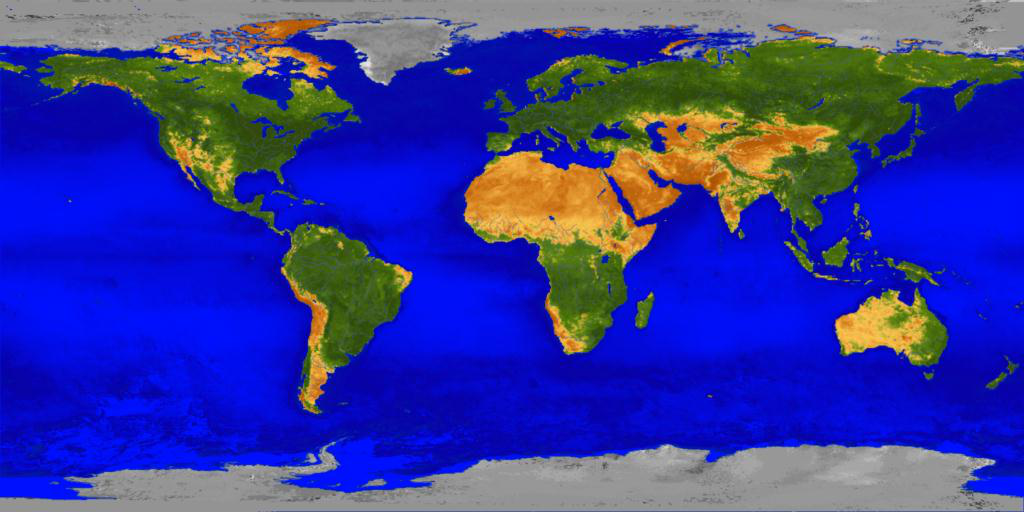

In [7]:
url = "https://www.evl.uic.edu/pape/data/Earth/1024/BigEarth.jpg"
image_file = UrlCached(url)
image = Image.open(image_file.fetch())
image

In [8]:
s.texture = image

## GeoJSON lines on a globe

Render lines extracted from GeoJSON data on a globe:

In [9]:
def line_coords(gj):
    """Yield lines in given GeoJSON/TopoJSON object as lists of [lon, lat] coordinates.

    Ignores Point and MultiPoint types because they don't form lines.
    """
    gj_type = gj['type']

    if gj_type in ['LineString']:
        yield gj['coordinates']
    elif gj_type in ['MultiLineString', 'Polygon']:
        yield gj['coordinates']
    elif gj_type == 'MultiPolygon':
        for poly in gj['coordinates']:
            for line in poly:
                yield line
    elif gj_type == 'GeometryCollection':
        for geom in gj['geometries']:
            for line in line_coords(geom):
                yield line
    elif gj_type == 'FeatureCollection':
        for feat in gj['features']:
            for line in line_coords(feat):
                yield line
    elif gj_type == 'Feature':
        geom = gj['geometry']
        for line in line_coords(geom):
            yield line
    elif gj_type == 'Topology':  # TopoJSON
        transform = gj.get('transform', {})
        scale = transform.get('scale', [1.0, 1.0])
        translate = transform.get('translate', [0.0, 0.0])
        for arc in gj['arcs']:
            line = []
            prev = [0, 0]
            for point in arc:
                prev[0] += point[0]
                prev[1] += point[1]
                line.append((prev[0] * scale[0] + translate[0], prev[1] * scale[1] + translate[1]))
            yield line
    elif gj_type in ['Point', 'MultiPoint']:
        pass
    else:
        msg = f'Unknown GeoJSON/TopoJSON type: {gj_type}'
        raise ValueError(msg)

In [10]:
xyz = []
for line in line_coords(gj_data):
    if len(np.array(line).shape) < 2:
        line = line[0]
    L = len(line)
    if L == 1:
        line = line[0]
    z = [lonlat2xyz(lon, lat) for (lon, lat) in line]
    x, y, z = np.array(z).T
    xyz.append([x, y, z])

In [11]:
ipv.figure()
sphere(0, 0, 0, radius=1, num=60, texture=image)
for x, y, z in xyz:
    ipv.plot(x, y, z, color="limegreen")
ipv.show()

[screenshot](screenshot/geojson.gif)